In [1]:
import json
from collections import defaultdict, Counter
import pandas as pd

from spacy.lang.en.stop_words import STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

In [2]:
with open("data_cleaned.json") as f:
    data_cleaned = json.load(f)

book_id_to_author = {}
for d in data_cleaned:
    book_id_to_author[d["ebook_no"]] = d["author"]

with open("lemmatized_data.json") as f:
    data = json.load(f)

with open("lemmas.json") as f:
    lemmas = json.load(f)
    lemma = {k:v[0] for k, v in lemmas.items()}

In [3]:
book_words = defaultdict(set)
author_words = defaultdict(set)
for d in data:
    for t in d["text"].split():
        if t and t.isalpha():
            book_words[d["ebook_no"]].add(t.lower())
            author_words[book_id_to_author[d["ebook_no"]]].add(t.lower())

not_recognized = list()
book_frequency = defaultdict(int)
for book_id, words in book_words.items():
    for word in words:
        try:
            book_frequency[lemma[word]] += 1
        except:
            not_recognized.append(word)

In [4]:
Counter(not_recognized).most_common()

[('farth', 88),
 ('speciman', 84),
 ('disintereste', 66),
 ('wale', 65),
 ('belove', 58),
 ('kindre', 57),
 ('vanishe', 52),
 ('auspex', 41),
 ('extoll', 40),
 ('flander', 39),
 ('hercule', 39),
 ('hobbe', 39),
 ('versaille', 37),
 ('everlaste', 37),
 ('naple', 34),
 ('descarte', 33),
 ('furth', 32),
 ('ulysse', 32),
 ('amien', 32),
 ('hereaft', 31),
 ('messr', 31),
 ('possesse', 31),
 ('accurse', 30),
 ('unerre', 29),
 ('swinge', 29),
 ('cle', 29),
 ('aristophane', 28),
 ('pende', 27),
 ('jacque', 26),
 ('ruben', 26),
 ('marseille', 25),
 ('demosthene', 25),
 ('rheim', 25),
 ('perishe', 24),
 ('distinguishe', 24),
 ('phidia', 24),
 ('unaccompanie', 24),
 ('intersperse', 24),
 ('toujour', 24),
 ('uncease', 24),
 ('overbear', 23),
 ('unacquainte', 23),
 ('undiminishe', 23),
 ('leed', 22),
 ('glaci', 22),
 ('diminishe', 21),
 ('tufte', 21),
 ('scissor', 21),
 ('eave', 21),
 ('burnish', 21),
 ('unperceive', 20),
 ('fouri', 20),
 ('thier', 20),
 ('uncompromise', 20),
 ('pyrenee', 20),
 ('u

In [5]:
author_frequency = defaultdict(int)
for author, words in author_words.items():
    for word in words:
        if word in lemma:
            author_frequency[lemma[word]] += 1

In [6]:
document_frequency = defaultdict(int)
counts  = defaultdict(int)

keywords = set(
    [
        word
        for word, freq in sorted(
            book_frequency.items(), key=lambda df: df[1], reverse=False
        )
        if 215 > freq > 1
    ]
)


for d in data:
    for word, count in Counter([lemma[t.lower()] for t in d["text"].split() if lemma.get(t.lower()) in keywords]).most_common():
        document_frequency[word] += 1
        counts[word] += count

In [9]:
freqs = pd.concat([pd.Series(author_frequency), pd.Series(book_frequency), pd.Series(document_frequency),pd.Series(counts)],axis=1).reset_index()
freqs.columns = ["word", "author_count", "book_count", "chunk_count", "count"]
freqs = freqs[~freqs["count"].isna()].sort_values("count", ascending=False)
freqs["chars"] = freqs["word"].str.len()
freqs = freqs[~freqs["word"].isin(STOP_WORDS)]
freqs = freqs[freqs["count"] >= 50]
freqs = freqs[freqs["chunk_count"] >= 50]
freqs = freqs[freqs["chars"]>2]
freqs["per_chunk"] = freqs["count"] / freqs["chunk_count"]
freqs = freqs[freqs["per_chunk"]!=1]
freqs = freqs[(freqs["chars"] != 3) | freqs["chars"].isin(['art', 'war', 'god', 'tax']) ] 
# the only relevant 3 char words that I found

In [10]:
freqs

,word,author_count,book_count,chunk_count,count,chars,per_chunk
7295,money,42,204,4198.0,14289.0,5,3.403764
8866,price,39,187,3426.0,13196.0,5,3.851722
618,class,49,214,5120.0,12477.0,5,2.436914
6846,capital,40,189,3348.0,11509.0,7,3.437575
470,king,38,192,3373.0,10820.0,4,3.207827
...,...,...,...,...,...,...,...
18113,criminality,14,28,50.0,51.0,11,1.020000
11743,terribly,18,38,50.0,51.0,8,1.020000
14221,sophisticate,11,24,50.0,51.0,12,1.020000
16918,professedly,12,38,50.0,51.0,11,1.020000


In [11]:
freqs = freqs[~freqs["word"].isin(["chapter", "footnote", "important", "importance"])]
# remove important and importance b/c of word "import"
freqs['snowball'] = freqs['word'].map(SnowballStemmer(language='english').stem)
freqs["porter"] = freqs["word"].map(PorterStemmer().stem)

/tmp/ipykernel_38419/125394888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqs['snowball'] = freqs['word'].map(SnowballStemmer(language='english').stem)
/tmp/ipykernel_38419/125394888.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqs["porter"] = freqs["word"].map(PorterStemmer().stem)


In [14]:
porter = freqs[["word", "porter"]].groupby("porter").agg(list)
porter_dict = porter['word'].to_dict()
snowball = freqs[["word", "snowball"]].groupby("snowball").agg(list)
snowball_dict = snowball['word'].to_dict()
freqs['snowball_combined_words'] = freqs['snowball'].map(snowball_dict)
freqs['porter_combined_words'] = freqs['porter'].map(porter_dict)

/tmp/ipykernel_38419/3600172265.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqs['snowball_combined_words'] = freqs['snowball'].map(snowball_dict)
/tmp/ipykernel_38419/3600172265.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqs['porter_combined_words'] = freqs['porter'].map(porter_dict)


In [18]:
# snowball is better because of community (porter combines with communicate) and cost (porter does not combine with costly)
freqs[["word","snowball_combined_words","porter_combined_words"]][freqs["word"].isin(["cost", "community"])]

,word,snowball_combined_words,porter_combined_words
5532,cost,"[cost, costly]",[cost]
9021,community,[community],"[community, communicate, communication, commun..."


In [19]:
freqs[["word","snowball_combined_words"]][freqs["word"].isin(["socialism", "product", "nation", "capital", "capitalism", "business", "duty"])]

,word,snowball_combined_words
6846,capital,"[capital, capitalism, capitalization, capitalize]"
8631,nation,"[nation, national, nationality, nationalism]"
8775,business,"[business, busy]"
6544,duty,"[duty, dutiful]"
4952,product,"[production, product, productive, productivity..."
18017,socialism,"[social, socialism, socially]"
26321,capitalism,"[capital, capitalism, capitalization, capitalize]"


In [23]:
snowball# = freqs[["word", "snowball"]].groupby("snowball").agg(list)
#snowball_dict = snowball['word'].to_dict()

,word
snowball,
abandon,"[abandon, abandonment]"
abat,"[abate, abatement]"
abb,[abbe]
abbey,[abbey]
abbot,[abbot]
...,...
zeno,[zeno]
zero,[zero]
zigzag,[zigzag]


In [28]:
snowball_stem_dict = freqs[["word", "snowball"]].set_index("word")["snowball"].to_dict()

In [33]:
for key in ["socialism", "production", "nation", "capital", "capitalism", "business", "duty"]:
    snowball_stem_dict[key] = key

In [34]:
for key in ['productive','productivity','productiveness','productively']:
    snowball_stem_dict[key] = 'productive'

In [39]:
freqs = freqs[['word', 'author_count', 'book_count', 'chunk_count', 'count']]

In [45]:
freqs["stem"] = freqs["word"].map(snowball_stem_dict)
stem_freqs = freqs[['stem', 'author_count', 'book_count', 'chunk_count', 'count']]

/tmp/ipykernel_38419/3532258823.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  freqs["stem"] = freqs["word"].map(snowball_stem_dict)


In [59]:
stem_freqs = stem_freqs.groupby("stem").agg(sum).reset_index().sort_values("count", ascending=False)

/tmp/ipykernel_38419/360701735.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  stem_freqs = stem_freqs.groupby("stem").agg(sum).reset_index().sort_values("count", ascending=False)


In [66]:
stem_freqs = stem_freqs[~stem_freqs["stem"].isin( ['relat',  'mere',  'particular',  'consequ',  'instanc'])]

/tmp/ipykernel_38419/4085972653.py:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  stem_freqs["count"].value_counts().sort_index()[:175].plot.bar()


<Axes: xlabel='count'>

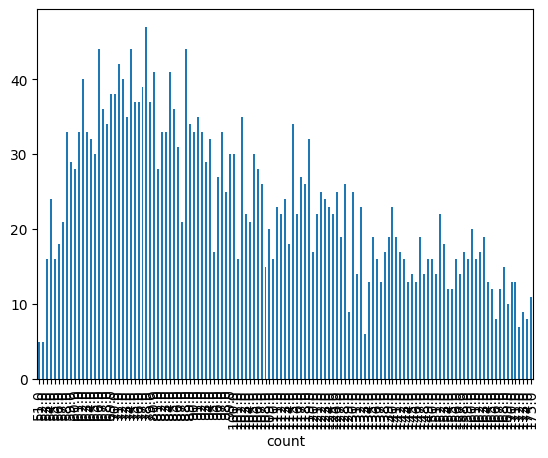

In [74]:
stem_freqs["count"].value_counts().sort_index()[:175].plot.bar()

<Axes: ylabel='Frequency'>

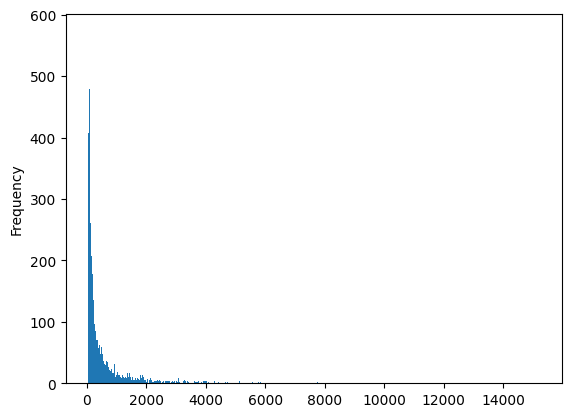

In [75]:
stem_freqs["count"].plot.hist(bins=1000)

In [120]:
stem_freqs = stem_freqs[stem_freqs["count"] > 52]
stem_freqs

,stem,author_count,book_count,chunk_count,count
4096,nation,120,478,7765.0,15207.0
3996,money,42,204,4198.0,14289.0
4763,price,39,187,3426.0,13196.0
1045,class,49,214,5120.0,12477.0
3208,industri,112,425,5558.0,12446.0
...,...,...,...,...,...
425,atroc,14,26,51.0,53.0
4292,outcast,13,35,51.0,53.0
2447,flutter,11,35,50.0,53.0
6405,unbridl,14,32,52.0,53.0


In [128]:
with open("stem_data.json", "w") as f:
    json.dump({
    "stems" : list(stem_freqs["stem"].to_list()),
    "word_to_stem": snowball_stem_dict,
    "stem_to_words": snowball_dict}, f)